In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True)

In [24]:
from random import shuffle, random

import numpy as np
import tensorflow as tf
from keras import Model, layers

from app.helpers import w3
from app.constants import TEST_PRIVATE_KEYS


class Actor:
    def __init__(self, private_key: str) -> None:
        self.account = w3.eth.account.from_key(private_key)

    def act(self, action):
        a1 = float(action[0][0])
        a2 = float(action[0][1])

        # Reward for taking action a1
        # Penalty for taking action a2
        return a1 - a2


class Env:
    model: Model = None
    actors: Actor = []
    optimizer = tf.optimizers.Adam()

    def __init__(self) -> None:
        self.create_model()
        self.actors = [Actor(pk) for pk in TEST_PRIVATE_KEYS]

    def _get_input(self, actor: Actor):
        # Static environment
        return np.array(
            [[0.5, 0.5, 0.5]],
            dtype=np.float64,
        )

    def create_model(self):
        num_inputs = 3
        num_actions = 2
        num_hidden = 128

        inputs = layers.Input(shape=(num_inputs,))
        common = layers.Dense(num_hidden, activation="relu")(inputs)
        action = layers.Dense(num_actions, activation="relu")(common)
        critic = layers.Dense(1)(common)

        self.model = Model(inputs=inputs, outputs=[action, critic])

    def train(self, n_actors=10, n_epochs=1, n_max_days=100, log_level=1):
        actors = self.actors.copy()[:n_actors]
        history = {}

        for actor in actors:
            history[actor.account.address] = {
                "estimate": [],
                "reward": [],
                "action": [],
                "loss": [],
            }

        for epoch in range(n_epochs):
            if log_level > 0:
                print(f"EPOCH: {epoch + 1}")

            shuffle(actors)

            for actor in actors:
                reward, estimate, loss, action = self.train_step(
                    actor, log_level=log_level
                )

                history[actor.account.address]["action"].append(action)
                history[actor.account.address]["reward"].append(reward)
                history[actor.account.address]["estimate"].append(estimate)
                history[actor.account.address]["loss"].append(loss)

        return history

    def train_step(self, actor: Actor, log_level=1):
        input = self._get_input(actor)

        with tf.GradientTape() as tape:
            # predict the action and estimate of value
            [action, critic] = self.model(input, training=True)

            # take the action
            reward = actor.act(action)

            # create a reward target and calculate the loss
            critic_loss = tf.keras.losses.Huber()(critic, reward)

            # calculate the action loss
            advantage = reward - critic
            search = tf.math.log(action + 1e-9)
            action_loss = -tf.reduce_sum(search * advantage)

            # calculate the total loss
            loss = critic_loss + action_loss

            # backpropagate
            vars = self.model.trainable_variables
            grad = tape.gradient(loss, vars)
            self.optimizer.apply_gradients(zip(grad, vars))

            if log_level > 1:
                print("   input:", input)
                print("  action:", action.numpy())
                print("  critic:", critic.numpy())
                print("  reward:", reward)
                # print("  search:", search)
                print("  C loss:", critic_loss.numpy())
                print("  A loss:", action_loss.numpy())
                print("    loss:", loss.numpy())

        return reward, critic.numpy()[0][0], loss.numpy(), action.numpy()

In [25]:
model = Env()
history = model.train(n_actors=1, n_epochs=100, n_max_days=100, log_level=2)

EPOCH: 1
   input: [[0.5 0.5 0.5]]
  action: [[0.12492928 0.        ]]
  critic: [[0.04925456]]
  reward: 0.124929279088974
  C loss: 0.0028633317
  A loss: 1.7256314
    loss: 1.7284946
EPOCH: 2
   input: [[0.5 0.5 0.5]]
  action: [[0.13115534 0.        ]]
  critic: [[0.07437268]]
  reward: 0.1311553418636322
  C loss: 0.0016121354
  A loss: 1.2920691
    loss: 1.2936813
EPOCH: 3
   input: [[0.5 0.5 0.5]]
  action: [[0.13729939 0.        ]]
  critic: [[0.09954009]]
  reward: 0.13729938864707947
  C loss: 0.00071288226
  A loss: 0.8574705
    loss: 0.8581834
EPOCH: 4
   input: [[0.5 0.5 0.5]]
  action: [[0.14316861 0.        ]]
  critic: [[0.12475972]]
  reward: 0.1431686133146286
  C loss: 0.0001694437
  A loss: 0.4172744
    loss: 0.41744384
EPOCH: 5
   input: [[0.5 0.5 0.5]]
  action: [[0.14848873 0.        ]]
  critic: [[0.1500361]]
  reward: 0.14848873019218445
  C loss: 1.1971714e-06
  A loss: -0.035017695
    loss: -0.0350165
EPOCH: 6
   input: [[0.5 0.5 0.5]]
  action: [[0.1524

/var/folders/m7/t60lf5qj4cn9hrlqv6y1t6dc0000gn/T/ipykernel_3143/2917671799.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


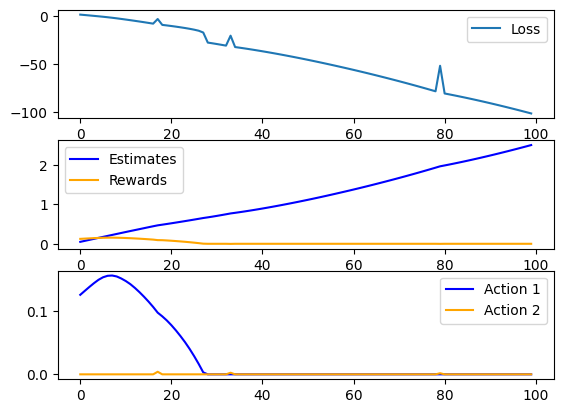

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
address = model.actors[0].account.address

ax1.plot(history[address]["loss"], label="Loss")
ax1.legend()

ax2.plot(history[address]["estimate"], color="blue", label="Estimates")
ax2.plot(history[address]["reward"], color="orange", label="Rewards")
ax2.legend()

actions = np.asarray(history[address]["action"])
ax3.plot(actions[:, 0:, 0], color="blue", label="Action 1")
ax3.plot(actions[:, 0:, 1], color="orange", label="Action 2")
ax3.legend()

fig.show()